# Cross section from radar HDF5-files

TODO 

Finnish Meteorological Institute is providing radar images as GeoTiff in S3 bucket. The data is free and openly available with CC4BY license.

This is a short and simple example how to calculate accumulated precipitation amount from GeoTiff radar images of precipitation rate (rr) with 5 minute interval. The example is ment to illustrate how to use the data with python.  

First we install necessary libraries. Rasterio (https://github.com/mapbox/rasterio) is used to fetch the data and pyproj (https://pypi.org/project/pyproj/) to calculate coordinate transformations.


In [3]:
!sudo yum install -y --enablerepo="epel" netcdf4-python gdal gdal-python

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
amzn-main                                                | 2.1 kB     00:00     
amzn-updates                                             | 3.8 kB     00:00     
1072 packages excluded due to repository priority protections
Package netcdf4-python-1.0.2-1.el6.x86_64 already installed and latest version
Package gdal-1.7.3-15.el6.x86_64 already installed and latest version
Package gdal-python-1.7.3-15.el6.x86_64 already installed and latest version
Nothing to do


```
conda create -c conda-forge --name fmiopendata ipykernel gdal dask arm_pyart xarray h5py h5netcdf tqdm
python -m ipykernel install --user --name fmiopendata --display-name "fmiopendata"
conda env export --name fmiopendata --file ~/fmiopendata.yml
```

In [4]:
!pip install --upgrade xarray h5py h5netcdf tqdm

Requirement already up-to-date: rasterio[s3] in /home/ec2-user/anaconda3/lib/python3.7/site-packages (1.1.5)
Requirement already up-to-date: xarray in /home/ec2-user/anaconda3/lib/python3.7/site-packages (0.16.0)
Requirement already up-to-date: s3fs in /home/ec2-user/anaconda3/lib/python3.7/site-packages (0.4.2)
Requirement already up-to-date: h5py in /home/ec2-user/anaconda3/lib/python3.7/site-packages (2.10.0)
Requirement already up-to-date: h5netcdf in /home/ec2-user/anaconda3/lib/python3.7/site-packages (0.8.0)
Requirement already up-to-date: tqdm in /home/ec2-user/anaconda3/lib/python3.7/site-packages (4.48.0)
Requirement already up-to-date: dask[complete] in /home/ec2-user/anaconda3/lib/python3.7/site-packages (2.20.0)
You should consider upgrading via the '/home/ec2-user/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
!conda install -y dask

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv

  added / updated specs:
    - dask


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bokeh-2.1.1                |           py36_0         5.4 MB
    distributed-2.20.0         |           py36_0        1011 KB
    immutables-0.14            |   py36h7b6447c_0          70 KB
    pillow-7.2.0               |   py36hb39fc2d_0         619 KB
    pyyaml-5.3.1               |   py36h7b6447c_1         180 KB
    ------------------------------------------------------------
                                           Total:         7.3 MB

The following NEW packages will be INSTALLED:

  bokeh              pkgs/main/linux-64::bokeh-2.1.1-py36_0
  click              pkgs/main/noarch::click-7.1.2-py_0
  cloudpickle        pkgs/main/noarch::cloudpickle-1.5.0-py_0
  contextvars     

In [36]:
!conda install -c conda-forge -y arm_pyart

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv

  added / updated specs:
    - arm_pyart


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arm_pyart-1.11.1           |   py36h785e9b2_1         3.2 MB  conda-forge
    cftime-1.2.0               |   py36h785e9b2_1         274 KB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    kiwisolver-1.2.0           |   py36hdb11119_0          87 KB  conda-forge
    matplotlib-base-3.1.1      |   py36hfd891ef_0         6.7 MB  conda-forge
    netcdf4-1.4.2              |   py36h808af73_0         480 KB
    scipy-1.5.1                |   py36h2d22ca

In [1]:
import xarray, h5py
import os, boto3
from datetime import datetime, timedelta

#from pyproj import Proj, Transformer
from osgeo import gdal
import wradlib as wrl

Following function opens the geotiff image from S3 bucket and sample pixel value from requested coordinates. Note that images are in EPSG:3067 projection so we need to reproject the coordinates. 

Finally, pixel values are converted to millimeters. Conversions are documented here: https://en.ilmatieteenlaitos.fi/open-data-manual-radar-data.

In [2]:
def download(bucket_name, key, dst_root='/tmp'):
    """ Download zarr directory from S3"""
    s3 = boto3.resource('s3')
    #resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    bucket = s3.Bucket(bucket_name) 
    dst_filename = '{}/{}'.format(dst_root, key)
    
    for object in bucket.objects.filter(Prefix = key):
        dst = dst_root+'/'+object.key
        if not os.path.exists(os.path.dirname(dst)):
            os.makedirs(os.path.dirname(dst))
        s3.meta.client.download_file(bucket_name, key, dst_filename) 
    
    return dst_filename

In [5]:
from dask import delayed

/tmp/h5/201112312355_radar.polar.fivan.h5
wradlib: Please wait for completion of time consuming task! 
wradlib: Please install 'tqdm' for showing a progress bar instead.
wradlib: Please wait for completion of time consuming task! 
wradlib: Please install 'tqdm' for showing a progress bar instead.
<wradlib.XRadVolume>
Dimension(s): (sweep: 2)
Elevation(s): (1.5, 3.0)
wradlib: Please wait for completion of time consuming task! 
wradlib: Please install 'tqdm' for showing a progress bar instead.
<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 500, time: 1)
Coordinates:
    longitude   float64 ...
    elevation   (azimuth) float32 ...
    sweep_mode  <U20 ...
    latitude    float64 ...
    rtime       (azimuth) datetime64[ns] ...
    altitude    float64 ...
  * range       (range) float32 250.0 750.0 1250.0 ... 249250.0 249750.0
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time        (time) datetime64[ns] 2011-12-31T23:55:58
Data variables:
    

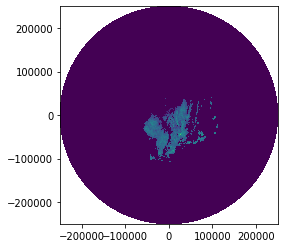

In [8]:
#%%time
fname = download('fmi-radar-opendata-sandbox', 'h5/201112312355_radar.polar.fivan.h5')
print(fname)
vol = wrl.io.xarray.open_odim(fname, loader='h5py', chunks={})
print(vol)
print(vol[0].data)
vol[0].data.pipe(wrl.georef.georeference_dataset).DBZH[0].wradlib.plot()

<xarray.DataArray 'DBZH' (time: 1, azimuth: 360, range: 500)>
dask.array<broadcast_to, shape=(1, 360, 500), dtype=float32, chunksize=(1, 360, 500), chunktype=numpy.ndarray>
Coordinates:
    longitude   float64 ...
    elevation   (azimuth) float32 ...
    sweep_mode  <U20 ...
    latitude    float64 ...
    rtime       (azimuth) datetime64[ns] ...
    altitude    float64 ...
  * range       (range) float32 250.0 750.0 1250.0 ... 249250.0 249750.0
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time        (time) datetime64[ns] 2011-12-31T23:55:58
    x           (azimuth, range) float32 2.1808696 6.5425987 ... -2176.3635
    y           (azimuth, range) float32 249.90216 749.7053 ... 249388.33
    z           (azimuth, range) float32 90.0 103.0 116.0 ... 10264.0 10291.0
    gr          (azimuth, range) float32 249.91168 749.7339 ... 249397.81
    rays        (azimuth, range) float32 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range)

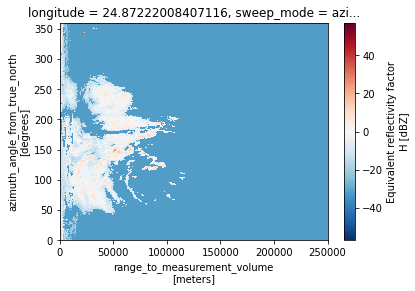

In [23]:
print(vol[0].data.DBZH)
vol[0].data.DBZH.plot()

In [37]:
print(vol[0].data.DBZH.loc[dict(time="2011-12-31T23:55:58")])

#vol[0].data.DBZH.loc[dict(time="2011-12-31T23:55:58")].plot.line(x='range')

<xarray.DataArray 'DBZH' (azimuth: 360, range: 500)>
dask.array<getitem, shape=(360, 500), dtype=float32, chunksize=(360, 500), chunktype=numpy.ndarray>
Coordinates:
    longitude   float64 ...
    elevation   (azimuth) float32 ...
    sweep_mode  <U20 ...
    latitude    float64 ...
    rtime       (azimuth) datetime64[ns] ...
    altitude    float64 ...
  * range       (range) float32 250.0 750.0 1250.0 ... 249250.0 249750.0
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    time        datetime64[ns] 2011-12-31T23:55:58
    x           (azimuth, range) float32 2.1808696 6.5425987 ... -2176.3635
    y           (azimuth, range) float32 249.90216 749.7053 ... 249388.33
    z           (azimuth, range) float32 90.0 103.0 116.0 ... 10264.0 10291.0
    gr          (azimuth, range) float32 249.91168 749.7339 ... 249397.81
    rays        (azimuth, range) float32 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float32 250.0 750.0 ... 24

In [4]:
def process_timestep(bucket, key, lat, lon, mode='rr', timestep=300):
    """ Process time step
    
    bucket   : str 
               S3 bucket name (where radar images exist)
    key      : str
               Radar image key in the bucket
    lat      : float
               Latitude of the point of interest
    lon      : float
               Longitude of the point of interest    
    mode     : str
               Defines how pixel values are converted to millimeters
    timestep : int
               Time step of radar images (used in pixel --> mm conversion)

    Returns
    -------
    float 
         Precipitation amount in millimeters
    """

    transformer = Transformer.from_crs("epsg:4326", "epsg:3067")
    x,y = transformer.transform(lat, lon)
    
    with rio.open('s3://{}/{}'.format(bucket, key)) as src:
        #print(src.profile)
        for val in src.sample([(x, y)]):
            if mode == 'rr':
                return val[0]*.01*timestep/3600
            else:
                raise Exception('mode not implemented')
        
    return 0

Last, we define a function to go through requested time range

In [5]:
def process_time_range(bucket, starttime, endtime, lat, lon, timestep, mode = 'rr', filename_start='', filename_end='_SUOMI500-rr.tif'):
    """ Process time range 
    bucket    : str 
                S3 bucket name (where radar images exist)
    starttime : str
                Start time of the time range in format %Y-%m-%d %H:%M:%S
    endtime   : str
                End time of the time range in format %Y-%m-%d %H:%M:%S                
    lat       : float
                Latitude of the point of interest
    lon       : float
                Longitude of the point of interest    
    timestep  : int
                Time step of radar images
    mode      : str
                Defines how pixel values are converted to millimeters
    filename_start : str
                     For example path of the image. Images are assumed to found with name 
                     filename_start+timestamp+filename_end.  
    filename_start : str
                 Images are assumed to found with name filename_start+timestamp+filename_end.  
                      
    Returns
    -------
    float 
         Precipitation amount in millimeters
    
    """
    
    start = roundTime(datetime.strptime(starttime, '%Y-%m-%d %H:%M:%S'))
    end = roundTime(datetime.strptime(endtime, '%Y-%m-%d %H:%M:%S'))    
    time_it = start
    
    prec_sum = 0
    while time_it <= end:
        key = '{}{}{}'.format(filename_start, time_it.strftime('%Y%m%d%H%M'), filename_end)
        prec_sum += process_timestep(bucket, key, lat, lon, timestep=timestep)

        if time_it.minute == 0: print('{:.2f}'.format(prec_sum), end='')
        else: print('.', end='')
            
        time_it +=  timedelta(seconds=timestep)

    print('')
    return prec_sum

And finally we run everything:

In [6]:
bucket = 'fmi-radar-opendata-sandbox'
starttime = '2020-07-10 00:00:00'
endtime = '2020-07-10 23:59:00'
lat = 63.1593
lon = 29.8346

prec_sum = process_time_range(bucket, starttime, endtime, lat, lon, 300)
print('Precipitation sum at {},{} (Koli, Finland) on 10th July 2020 is {:.2f} mm'.format(lat,lon,prec_sum))

0.00...........0.00...........0.03...........0.08...........0.09...........0.09...........0.09...........0.28...........0.30...........0.93...........2.14...........2.21...........2.51...........4.24...........4.63...........4.63...........5.13...........8.11...........8.11...........8.11...........8.11...........8.11...........8.11...........8.11...........8.11
Precipitation sum at 63.1593,29.8346 (Koli, Finland) on 10th July 2020 is 8.11 mm
